In [1]:
!pip install pillow

In [2]:
import time
import os
import multiprocessing as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Layer name to inspect
layer_name = 'block5_conv2'
temp = tf.zeros([4, 32, 32, 3])  # Or tf.zeros
preprocess_input(temp)
epochs = 30
step_size = .05
# filter_index = 1

# Create a connection between the input and the target layer
model = tf.keras.models.load_model('base_model_cifar10_vgg16.h5')


# Initiate random noise
input_img_data = np.random.random((1, 224, 224, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128.

# Cast random noise from np.float64 to tf.float32 Variable




In [3]:
targets = []
for i, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        targets.append(layer.name)
targets

['block1_conv1',
 'block1_conv2',
 'block2_conv1',
 'block2_conv2',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3']

In [4]:
%%time
for layer_name in targets[0:1]:
    print(f'generating dataset {layer_name}')
    submodel = tf.keras.models.Model([model.inputs[0]], 
                                     [model.get_layer(layer_name).output])
    for filter_index in range(submodel.output.get_shape()[-1]):
        input_img_data = np.random.random((1, 224, 224, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128.
        input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))
        for _ in range(epochs):
            with tf.GradientTape() as tape:
                outputs = submodel(preprocess_input(input_img_data))
                loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
            grads = tape.gradient(loss_value, input_img_data)
            normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
            input_img_data.assign_add(normalized_grads * step_size)
        image = input_img_data.numpy()[0,:,:,:].astype(np.uint8)
        p = mp.Process(target=Image.fromarray(image).save(fp=f'./synth_sets/vgg16_cifar10/{layer_name}_{filter_index}.jpg'))
        p.start()

generating dataset block1_conv1
CPU times: user 9.01 s, sys: 2.86 s, total: 11.9 s
Wall time: 11 s


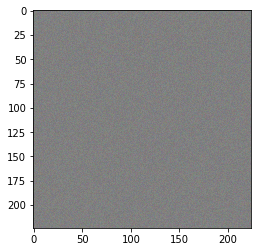

In [5]:
plt.imshow(input_img_data.numpy()[0,:,:,:].astype(np.uint8))

In [6]:
Image.fromarray(input_img_data.numpy()[0,:,:,:].astype(np.uint8)).save(fp='test.jpg')

In [7]:
np.argmax(model(input_img_data).numpy())

ValueError: Incompatible type conversion requested to type 'float32' for variable of type 'float16'